In [12]:
import cv2
import os, sys
import copy
import torch
import yaml

import numpy as np
from time import time

from utils.parameter import read_image

from utils_point.my_point_model import create_pointextract_instance, create_pointmatch_instance
from  utils_line.my_line_model import create_lineextract_instance, create_linematch_instance
opencv_method = ["orb"]

修改：inlier_cnt 12-10，RANSAC参数0.99-0.8，config文件中的迭代次数和阈值

In [1]:
yamlPath = "/home/nnplvio_r2d2_ws/src/sp-sold2-vins/config/feature_tracker/euroc_config.yaml"
with open(yamlPath,'rb') as f:
    params = yaml.load(f, Loader=yaml.FullLoader)
    line_params = params["line_feature_cfg"]
    camera_params = params["camera_cfg"]
    extract_method = line_params["extract_method"]


my_lineextract_model = create_lineextract_instance(line_params)  # 建立自定义点特征提取模型
my_linematch_model = create_linematch_instance(line_params)  # 建立自定义点特征匹配模型
# camera_model = CameraModel(camera_params)   
# CameraIntrinsicParam = camera_model.generateCameraModel()   # 建立相机模型
# feature_tracker = FeatureTracker(my_pointextract_model, my_pointmatch_model, CameraIntrinsicParam,
#                                     min_cnt=point_params["min_cnt"], opencv=opencv) # 利用点特征模型和相机模型生成点特征处理器

NameError: name 'yaml' is not defined

In [14]:
# img0 = np.load("/home/nnplvio_r2d2_ws/src/sp-sold2-vins/notebook/img/0.npy")
# img1 = np.load("/home/nnplvio_r2d2_ws/src/sp-sold2-vins/notebook/img/1.npy")
img0 = cv2.imread("/home/sharedocker/img/0.png", 0)
img1 = cv2.imread("/home/sharedocker/img/6.png", 0)

# print(img0.shape)
keylines0, linesdescriptor0, valid_point0 =  my_lineextract_model.extract(img0)
keylines1, linesdescriptor1, valid_point1 =  my_lineextract_model.extract(img1)

print(keylines0.shape, keylines1.shape)

(389, 2, 2) (302, 2, 2)


In [20]:
index_lines0, index_lines1 = my_linematch_model.match( 
									keylines0,
									keylines1,
									linesdescriptor0[None,...], 
									linesdescriptor1[None,...],
									valid_point0,
									valid_point1
							)
print("line match size is :", index_lines0.shape[0])


line match size is : 178


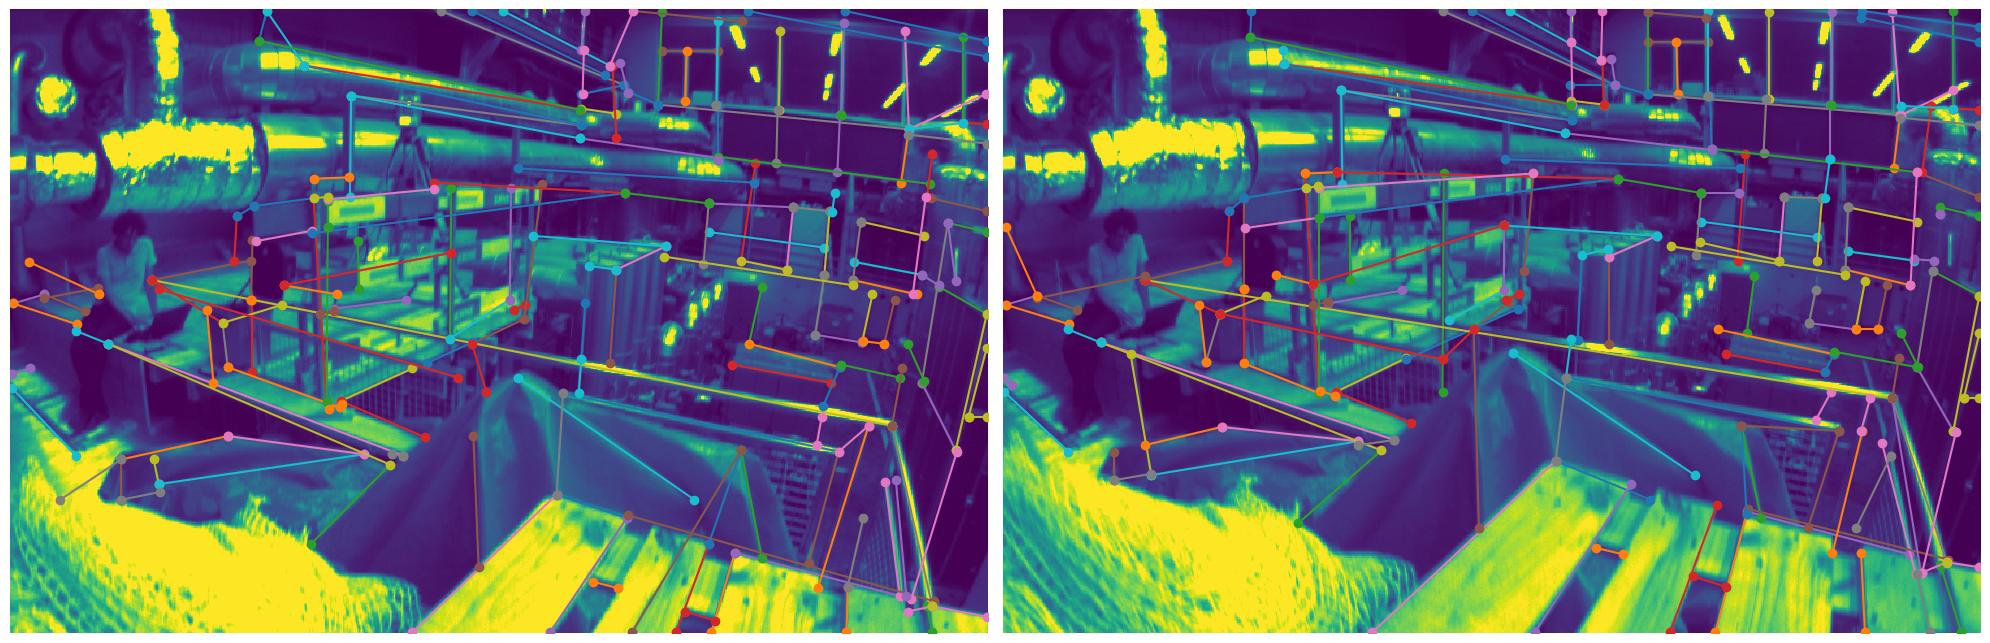

In [23]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# Display images side by side
ax1.imshow(img0)
ax2.imshow(img1)
ax1.axis('off')
ax2.axis('off')
# Set the limits for the x-axis to match the image widths
# ax1.set_xlim(0, img0.shape[1])
# ax2.set_xlim(img0.shape[1], img0.shape[1] + img1.shape[1])
# # Set the limits for the y-axis to match the image height
# ax1.set_ylim(img0.shape[0], 0)
# ax2.set_ylim(img1.shape[0], 0)
# # Draw matching lines using the matches coordinates
for i in range(index_lines0.shape[0]):
    # Extract matching points coordinates
    line0index = int(index_lines0[i])
    line1index = int(index_lines1[i])


    line0_spx = int(round(keylines0[line0index,0,1]))
    line0_spy = int(round(keylines0[line0index,0,0]))

    line0_epx = int(round(keylines0[line0index,1,1]))
    line0_epy = int(round(keylines0[line0index,1,0]))


    line1_spx = int(round(keylines1[line1index,0,1]))
    line1_spy = int(round(keylines1[line1index,0,0]))

    line1_epx = int(round(keylines1[line1index,1,1]))
    line1_epy = int(round(keylines1[line1index,1,0]))


    # Draw lines on the images
    # ax1.plot([point1[0]], [point1[1]], 'bo')  # First image point
    # ax1.text(point1[0], point1[1], str(i))
    # ax2.plot([point2[0]], [point2[1]], 'ro')  # Second image point
    # ax2.text(point2[0], point2[1], str(i))

    # ax1.plot([point1[0], img0.shape[1]+point2[0]], [point1[1], point2[1]], c='g', linestyle='--', label='Match')
    ax1.plot([line0_spx, line0_epx], [line0_spy, line0_epy], marker='o')
    ax2.plot([line1_spx, line1_epx], [line1_spy, line1_epy], marker='o')

# Set the aspect ratio to be the same for both subplots
plt.tight_layout()
# Show the plot
plt.show()


In [ ]:
import numpy as np
            
vecpoint_tracked = np.zeros((3,0))
pointID_tracked = []
descr_tracked = np.zeros((256,0))
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
for i in range(10):
    vecpoint_new = np.zeros((3,0))
    pointID_new = []
    descr_new = np.zeros((128,0))

    img = cv2.imread("/home/sharedocker/img/"+str(i)+".png", 0)
    keyPoint, pointdescriptor =  my_pointextract_model.extract(img)
    num_points = keyPoint.shape[1]

    if i == 0:
        # ax1.imshow(img)
        vecpoint_tracked = keyPoint
        pointID_tracked = np.arange(num_points)
        descr_tracked = pointdescriptor
        continue
    matches = my_pointmatch_model.match({
										"descriptors0": descr_tracked,
	  									"descriptors1": pointdescriptor,
										"keypoints0": vecpoint_tracked,
										"keypoints1": keyPoint,
										"shape": img.shape
									})
    matches_num = matches.shape[1]
    for j in range(matches_num):
        index_l = int(matches[0,j])
        index_r = int(matches[1,j])
        vecpoint_new=np.append(vecpoint_new, keyPoint[:,index_r:index_r+1], axis=1)
        descr_new=np.append(descr_new, pointdescriptor[:,index_r:index_r+1], axis=1)
    vecpoint_tracked = vecpoint_new
    descr_tracked = descr_new
    print(keyPoint.shape, vecpoint_tracked.shape)

    # for k in range(matches_num):
    #     # Extract matching points coordinates
    #     point = vecpoint_tracked[:,k]
    #     # point2 = keyPoint1[:-1, int(matches[1, i])]
        
    #     # Convert points to integers
    #     # point1 = tuple(map(int, point1))
    #     # point2 = tuple(map(int, point2))
        
    #     # Draw lines on the images
    #     # ax1.plot([point1[0]], [point1[1]], 'bo')  # First image point
    #     # ax1.text(point1[0], point1[1], str(i))
    #     x = int(point[0])
    #     y = int(point[1])
    #     ax2.plot([x], [y], 'ro')  # Second image point
    #     ax2.text(x, y, str(k))
    #     plt.tight_layout()
    #     # Show the plot
    #     plt.show()



superglue tracking is bad